In [1]:
# import libraries
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import sklearn as sk
from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing
import arviz as az
import seaborn as sns; sns.set()
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
import warnings
from sklearn.covariance import EllipticEnvelope
warnings.filterwarnings('ignore')

In [28]:
# step 1 - read data
# read the original medical insurance data
original_data = pd.read_csv("Wine_Quality.csv")
original_data.head()

# make it copy
data = original_data.copy()
data.head(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7


In [3]:
# step 2 - clean up the data
data.isnull().sum()/len(data) # no missing values

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

In [4]:
# step 3: deal with outliers from the data
data.shape # (1599, 12)
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<AxesSubplot:xlabel='free sulfur dioxide'>

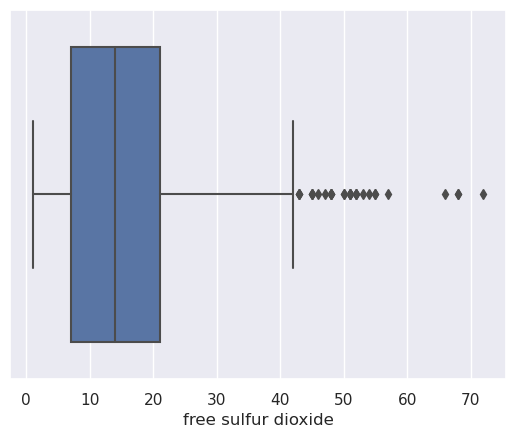

In [5]:
# example to show the first two columns values in boxplot
import seaborn as sns
sns.boxplot(data['free sulfur dioxide'])

<AxesSubplot:xlabel='fixed acidity'>

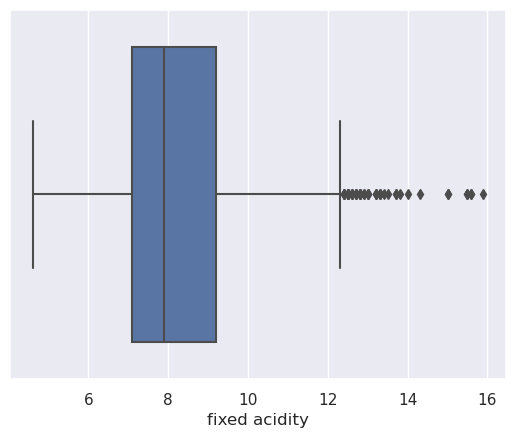

In [6]:
sns.boxplot(data['fixed acidity'])

In [7]:
outlier_list = []
for i in range(len(data.columns)-1): # the 12th column is target
    # IQR
    Q1 = np.percentile(data.iloc[:,i], 25, interpolation = 'midpoint')
    Q3 = np.percentile(data.iloc[:,i], 75,interpolation = 'midpoint')
    IQR = Q3 - Q1
    # set the boundary of the upper and lower value
    upper_bound = data[data.iloc[:,i] >= (Q3+1.5*IQR)].index.to_list()
    lower_bound = data[data.iloc[:,i] <= (Q1-1.5*IQR)].index.to_list()
    outlier_list.extend(upper_bound)
    outlier_list.extend(lower_bound)
    #print(data.columns[i])
    
# update dataset by dropping outliers
data = data[~data.index.isin(pd.Series(outlier_list).drop_duplicates())]
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
# recheck the ourliers have been removed
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,8.164706,0.522853,0.247882,2.185126,0.078475,14.947899,41.985714,0.996571,3.324277,0.632252,10.365742,5.639496
std,1.461982,0.164905,0.180214,0.442208,0.014314,8.758452,25.904021,0.001604,0.131934,0.116385,0.975640,0.764181
min,5.100000,0.120000,0.000000,1.200000,0.041000,1.000000,6.000000,0.992350,2.940000,0.330000,8.700000,3.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995503,3.230000,0.550000,9.500000,5.000000
50%,7.800000,0.520000,0.240000,2.100000,0.078000,13.000000,36.000000,0.996600,3.330000,0.610000,10.100000,6.000000
75%,9.000000,0.630000,0.390000,2.500000,0.087000,20.000000,55.000000,0.997575,3.407500,0.700000,11.000000,6.000000
max,12.300000,1.005000,0.730000,3.600000,0.119000,41.000000,121.000000,1.001000,3.680000,0.980000,13.400000,8.000000


<AxesSubplot:xlabel='free sulfur dioxide'>

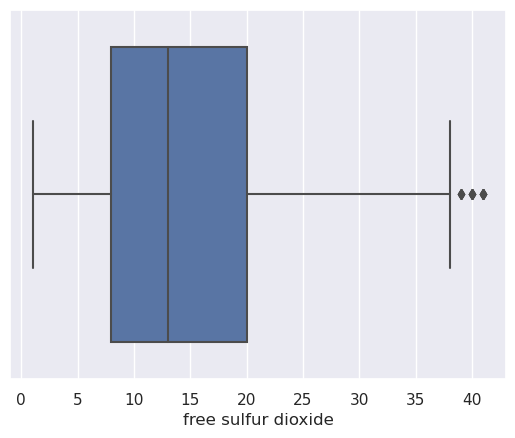

In [9]:
# testing again which shows the outlier has been removed 
sns.boxplot(data['free sulfur dioxide'])

<AxesSubplot:xlabel='fixed acidity'>

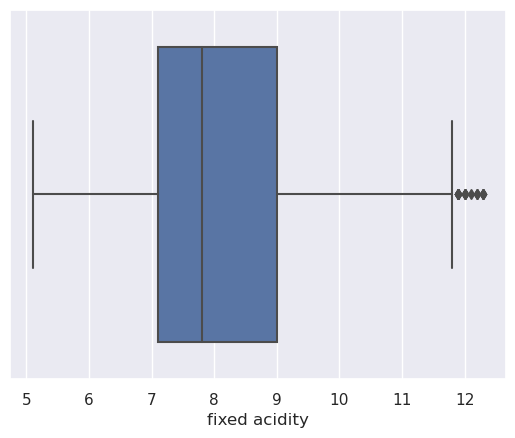

In [10]:
sns.boxplot(data['fixed acidity'])

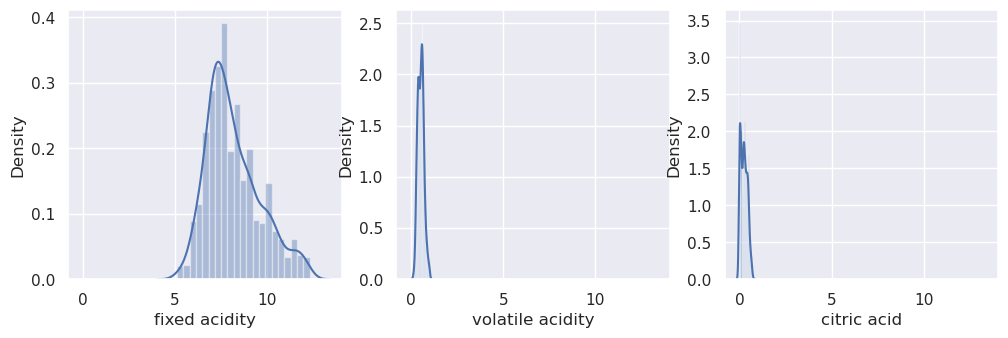

In [11]:
# step 4 - plot the varialbes check whether they are normal distribution or not.
fig, axes = plt.subplots(1,3, sharex=True, figsize=(12,3.5))
for i in range(data.iloc[:,:3].columns.size):
    sns.distplot(data.iloc[:,i],ax=axes[i])

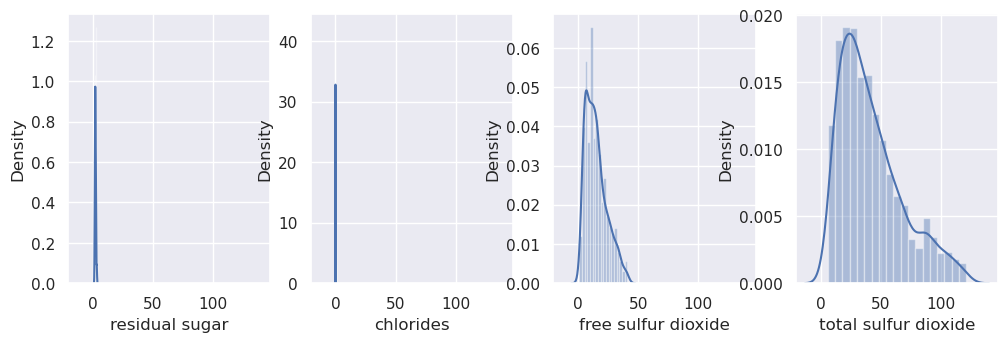

In [12]:
fig, axes = plt.subplots(1,4, sharex=True, figsize=(12,3.5))
df = data.iloc[:,3:7]
for i in range(data.iloc[:,:4].columns.size):
    sns.distplot(df.iloc[:,i],ax=axes[i])

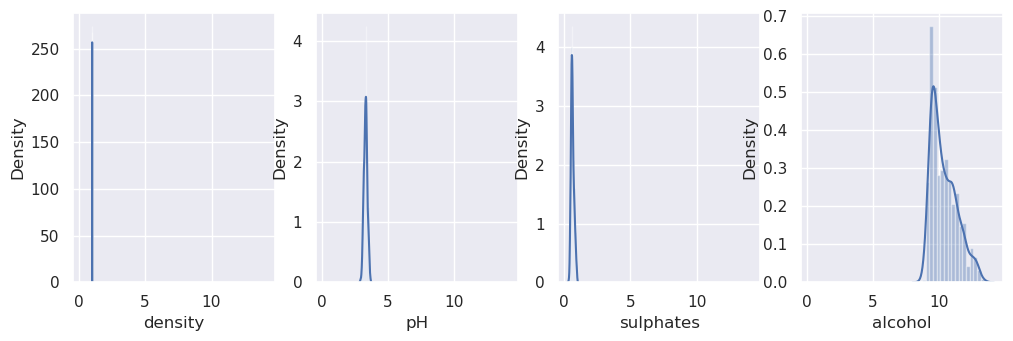

In [13]:
fig, axes = plt.subplots(1,4, sharex=True, figsize=(12,3.5))
df = data.iloc[:,7:11]
for i in range(data.iloc[:,:4].columns.size):
    sns.distplot(df.iloc[:,i],ax=axes[i])

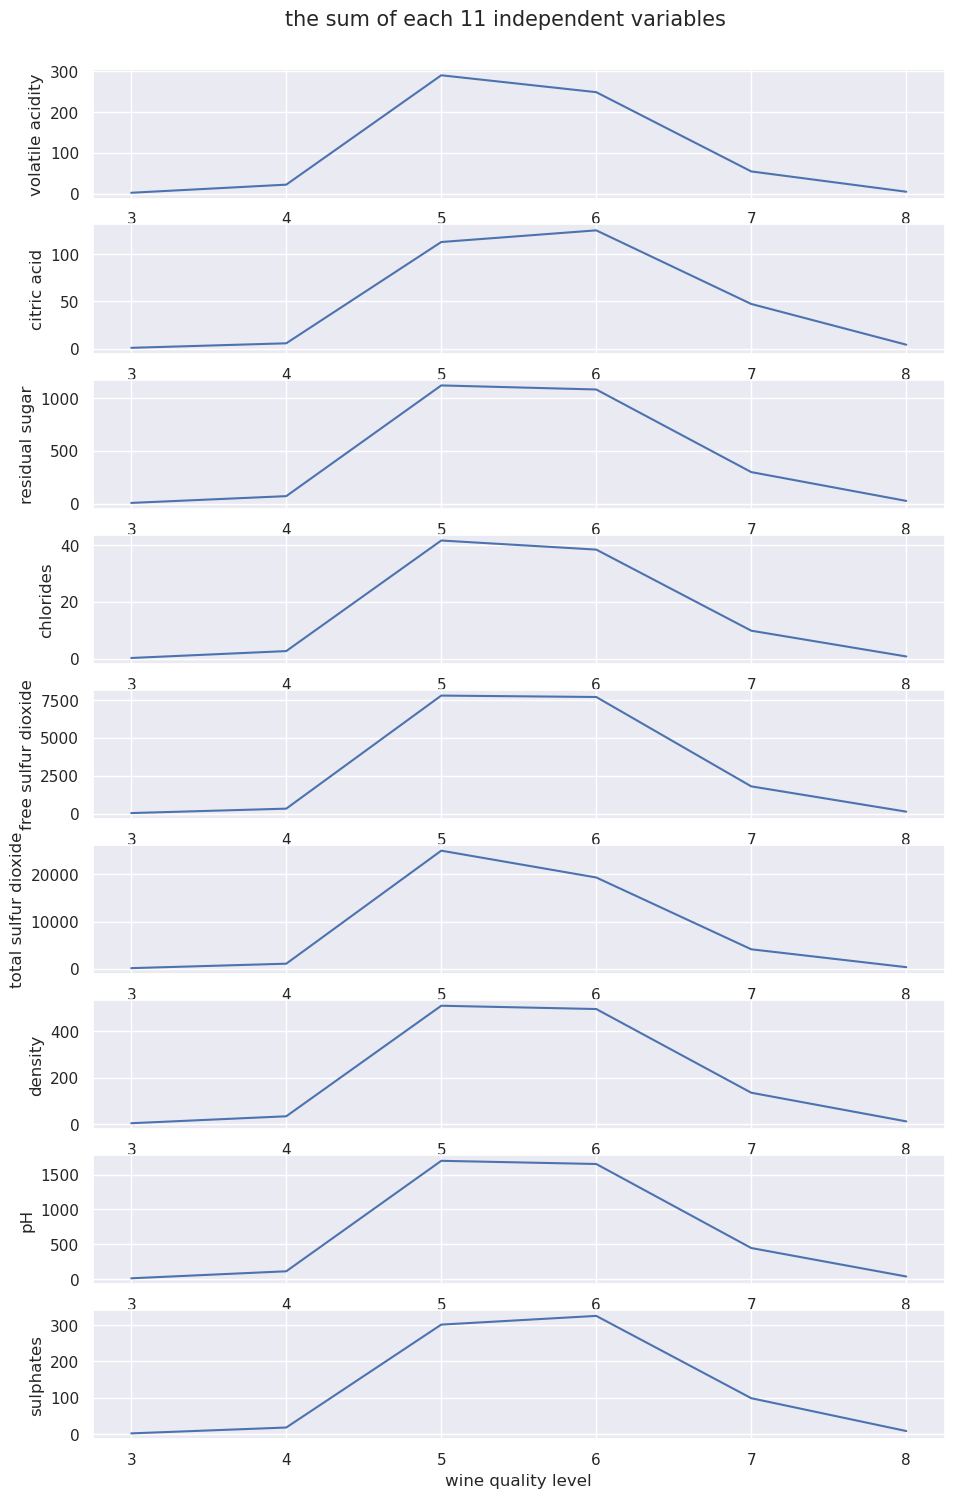

In [14]:
# step 5 Read all wine  indenpendent variables data and show it using a multiline plot.
# applying groupby() function to group the data on quality value.

# plot1. set figure with costom size
group_df=data.groupby(by='quality',sort=True).sum()

fig=plt.figure(figsize=(11,20))
fig.suptitle("the sum of each 11 independent variables",size=15)
# print 10 stocks into each subplot.
for i in range(1,len(group_df.columns)-1):
    plt.subplot(11,1,i)
    plt.plot(group_df.iloc[:,i])
    plt.xlabel("wine quality level")
    plt.ylabel(group_df.columns[i])

# adjust the subtitle location
fig.subplots_adjust(top=0.95)
plt.show()

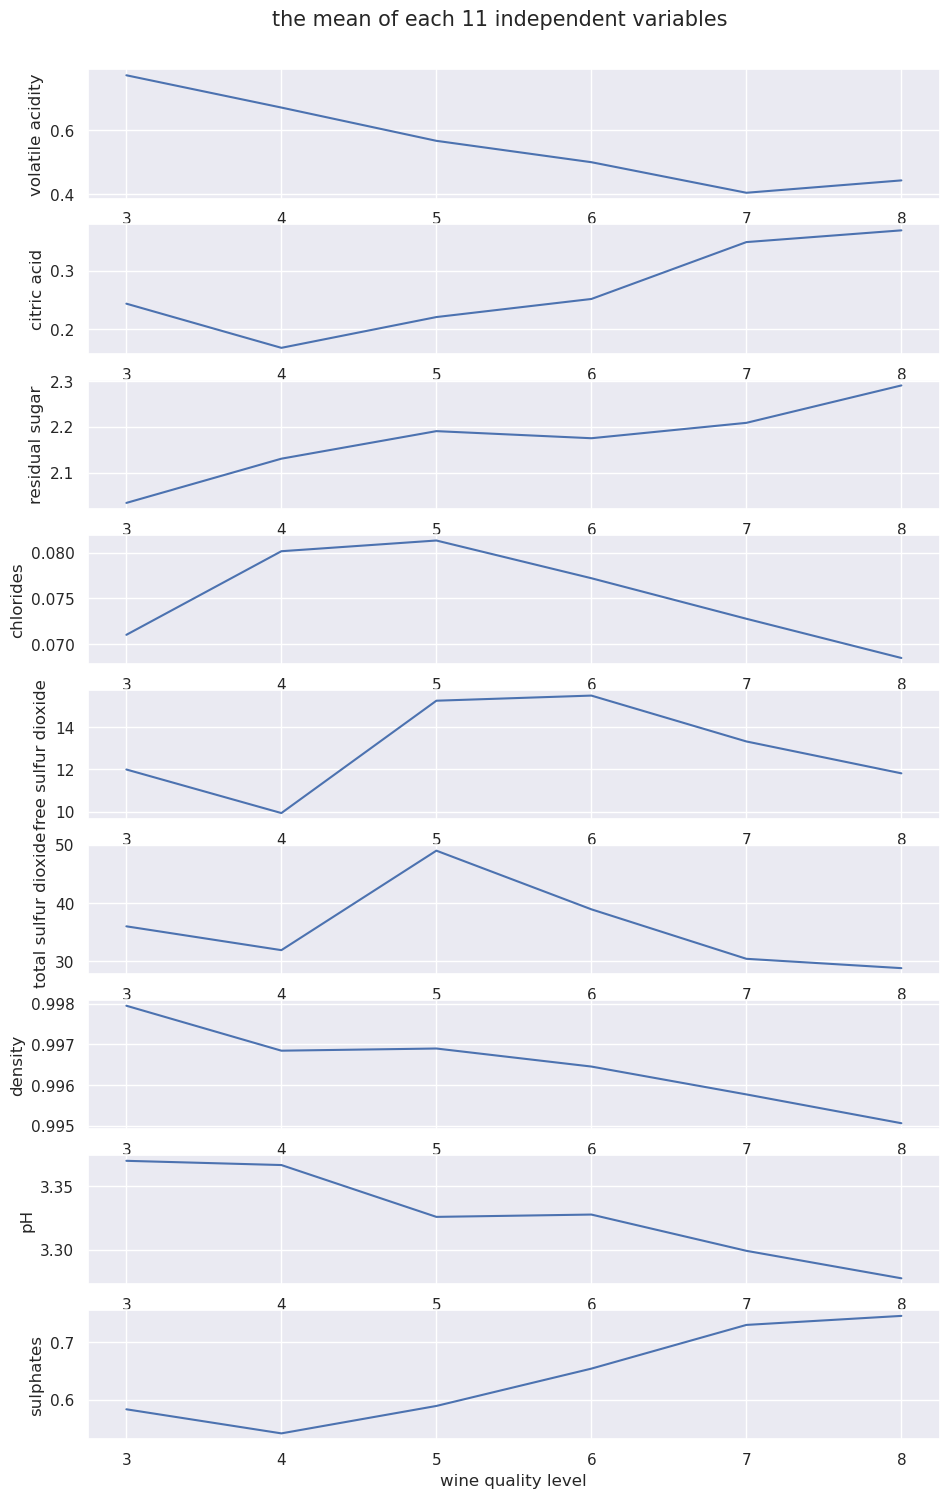

In [15]:
# plot2. set figure with costom size
group_df=data.groupby(by='quality',sort=True).mean()

fig=plt.figure(figsize=(11,20))
fig.suptitle("the mean of each 11 independent variables",size=15)
# print 10 stocks into each subplot.
for i in range(1,len(group_df.columns)-1):
    plt.subplot(11,1,i)
    plt.plot(group_df.iloc[:,i])
    plt.xlabel("wine quality level")
    plt.ylabel(group_df.columns[i])

# adjust the subtitle location
fig.subplots_adjust(top=0.95)
plt.show()

In [16]:
# resort the values of the df
# data_copy = data.sort_values(by='quality').reset_index()
# data_copy = data_copy.drop('index',axis=1)
# data_copy

In [17]:
# step6 what are the correlation between each variables
cor_all = data.corr()
print(cor_all.quality) # to check the correlation between each variables with quality
cor_all

fixed acidity           0.109050
volatile acidity       -0.350862
citric acid             0.218092
residual sugar          0.019087
chlorides              -0.193017
free sulfur dioxide    -0.010851
total sulfur dioxide   -0.200204
density                -0.232870
pH                     -0.070198
sulphates               0.417274
alcohol                 0.509549
quality                 1.000000
Name: quality, dtype: float64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.274386,0.662009,0.231622,0.197002,-0.153762,-0.094231,0.609033,-0.684422,0.161037,-0.040197,0.109050
volatile acidity,-0.274386,1.000000,-0.628285,0.026781,0.113235,-0.015116,0.104755,0.042256,0.226752,-0.317661,-0.221090,-0.350862
citric acid,0.662009,-0.628285,1.000000,0.154590,0.071053,-0.074823,-0.004786,0.304327,-0.474527,0.257718,0.140575,0.218092
residual sugar,0.231622,0.026781,0.154590,1.000000,0.232999,0.085781,0.188752,0.391961,-0.059462,0.045068,0.102149,0.019087
chlorides,0.197002,0.113235,0.071053,0.232999,1.000000,0.015030,0.173770,0.412567,-0.174386,-0.081419,-0.304244,-0.193017
free sulfur dioxide,-0.153762,-0.015116,-0.074823,0.085781,0.015030,1.000000,0.621532,-0.022246,0.151452,0.105065,-0.022929,-0.010851
total sulfur dioxide,-0.094231,0.104755,-0.004786,0.188752,0.173770,0.621532,1.000000,0.144718,0.017380,-0.051314,-0.241994,-0.200204
density,0.609033,0.042256,0.304327,0.391961,0.412567,-0.022246,0.144718,1.000000,-0.226178,0.070553,-0.544655,-0.232870
pH,-0.684422,0.226752,-0.474527,-0.059462,-0.174386,0.151452,0.017380,-0.226178,1.000000,0.012753,0.122349,-0.070198
sulphates,0.161037,-0.317661,0.257718,0.045068,-0.081419,0.105065,-0.051314,0.070553,0.012753,1.000000,0.272715,0.417274


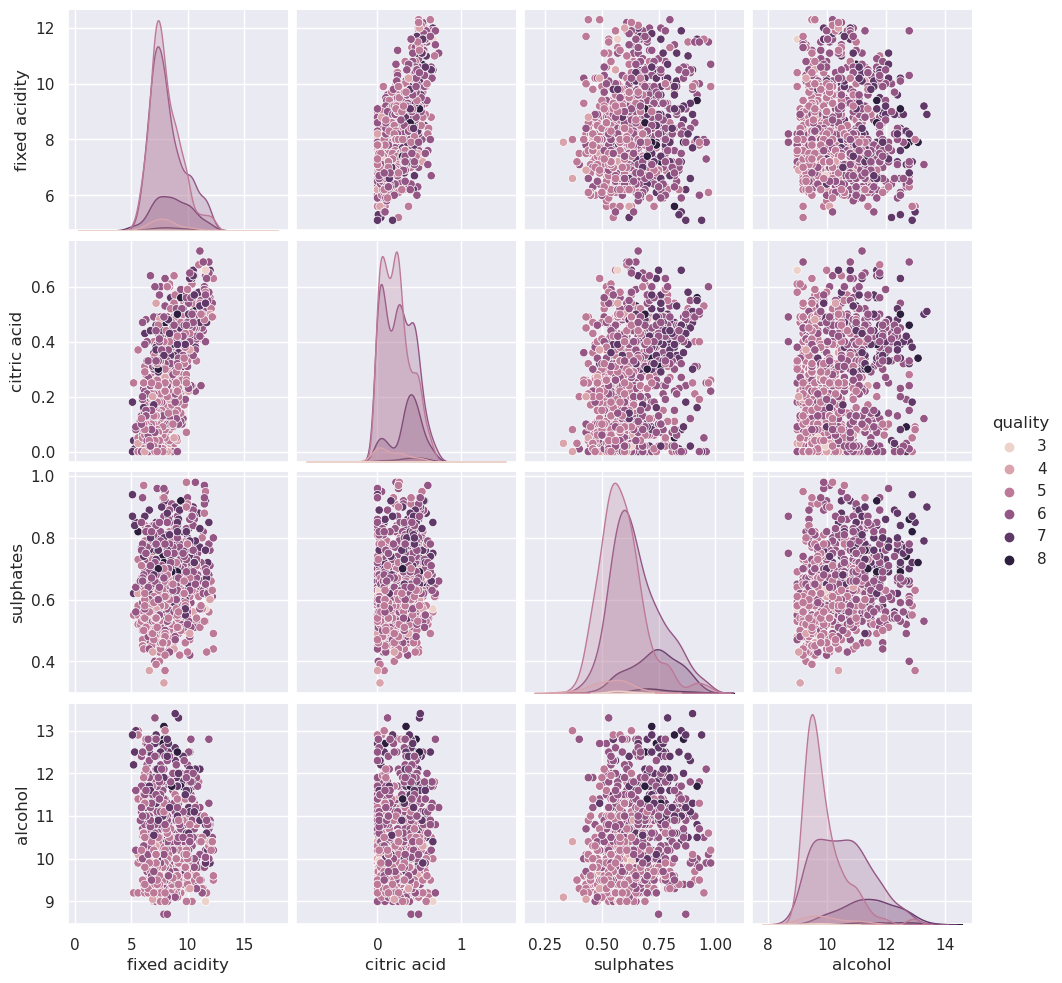

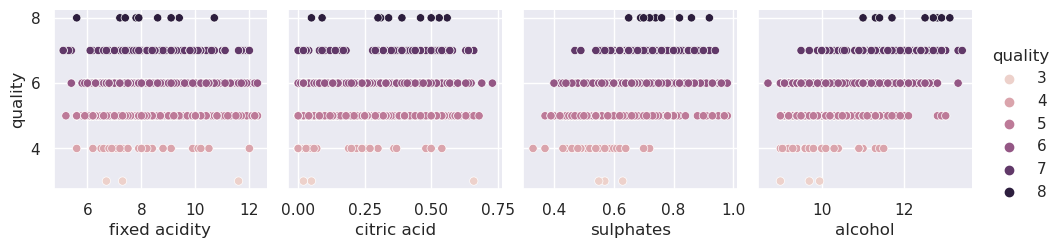

In [18]:
# remove some negative value then plot the data
cor_data= data[['fixed acidity','citric acid','sulphates','alcohol','quality']]

sns.pairplot(cor_data,hue='quality')
sns.pairplot(cor_data,x_vars=['fixed acidity','citric acid','sulphates','alcohol'],y_vars=['quality'],hue='quality')

In [19]:
cor_data
# data

,fixed acidity,citric acid,sulphates,alcohol,quality
0,7.4,0.00,0.56,9.4,5
1,7.8,0.00,0.68,9.8,5
2,7.8,0.04,0.65,9.8,5
3,11.2,0.56,0.58,9.8,6
4,7.4,0.00,0.56,9.4,5
...,...,...,...,...,...
1594,6.2,0.08,0.58,10.5,5
1595,5.9,0.10,0.76,11.2,6
1596,6.3,0.13,0.75,11.0,6
1597,5.9,0.12,0.71,10.2,5


In [20]:
# step 7 Using Multiple Linear Regression method to analysis the wine quality data

# model 1 (all independent variables)
from sklearn.model_selection import train_test_split
from sklearn import metrics

# use all independent variables becomes X, and Profit is assigned to dependent variable y
X = data.iloc[:,:11].values
y = data['quality']

# split the dataset to training set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
# testing purpose
# X_train.shape # 952,4
# X_test.shape # 238,4
# y_train.shape # 952
# y_test.shape # 238

# create a initial linear regression model
model = LinearRegression(fit_intercept=True)
# train the model with X,y train values
model.fit(X_train,y_train)
# to make predictions on the test data.
y_predict = model.predict(X_test)
# compare the actual output values for X_test with the predicted values
dataframe = pd.DataFrame({"Actual":y_test,"Predicted":y_predict})
print(dataframe.head())

# use Ordinear least square to check which variables are more relavent to the target
model = sm.OLS(y, X) 
OLS = model.fit()  
OLS.summary()

      Actual  Predicted
1153       6   6.057523
1180       6   6.303604
722        5   5.680106
883        5   5.013970
542        5   5.489795


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                quality   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              9648.
Date:                Mon, 10 Oct 2022   Prob (F-statistic):                        0.00
Time:                        00:20:44   Log-Likelihood:                         -1073.7
No. Observations:                1190   AIC:                                      2169.
Df Residuals:                    1179   BIC:                                      2225.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0020      0.021     -0.095      0.924      -0.044       0.040
x2            -0.8746      0.149     -5.883      0.000      -1.166      -0.583
x3            -0.3339      0.170     -1.963      0.050      -0.668      -0.000
x4            -0.0099      0.044     -0.227      0.820      -0.096       0.076
x5            -1.7598      1.354     -1.300      0.194      -4.415       0.896
x6             0.0031      0.003      1.147      0.252      -0.002       0.008
x7            -0.0025      0.001     -2.627      0.009      -0.004      -0.001
x8             4.5559      0.761      5.990      0.000       3.064       6.048
x9            -0.7359      0.192     -3.831      0.000      -1.113      -0.359
x10            1.7059      0.166     10.268      0.000       1.380       2.032
x11            0.3129      0.021     15.087      0.000       0.272       0.354
==============================================================================
Omnibus:                        8.101   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               11.062
Skew:                          -0.004   Prob(JB):                      0.00396
Kurtosis:                       3.472   Cond. No.                     4.18e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test,y_predict))
mse = metrics.mean_squared_error(y_test,y_predict)
print("Mean Squared Error (MSE): ",mse)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_predict))
print("Root Mean Squared Error (RMSE):",RMSE)

# set a parameter table to compare the RMSE
results= pd.DataFrame()
results['name'] = ['method1']
results['RMSE'] = RMSE
results

Mean Absolute Error (MAE): 0.4776147288551583
Mean Squared Error (MSE):  0.38021459722275563
Root Mean Squared Error (RMSE): 0.6166154370616711


,name,RMSE
0,method1,0.616615


In [25]:
# model 2 (some correlative independent variables)
# use all independent variables becomes X, and Profit is assigned to dependent variable y
X = cor_data[['fixed acidity','citric acid','sulphates','alcohol']].values
y = cor_data['quality']

# split the dataset to training set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
# testing purpose
# X_train.shape # 952,4
# X_test.shape # 238,4
# y_train.shape # 952
# y_test.shape # 238

# create a initial linear regression model
model = LinearRegression(fit_intercept=True)
# train the model with X,y train values
model.fit(X_train,y_train)
# to make predictions on the test data.
y_predict = model.predict(X_test)
# compare the actual output values for X_test with the predicted values
dataframe = pd.DataFrame({"Actual":y_test,"Predicted":y_predict})
print(dataframe.head())


print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test,y_predict))
mse = metrics.mean_squared_error(y_test,y_predict)
print("Mean Squared Error (MSE): ",mse)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_predict))
print("Root Mean Squared Error (RMSE):",RMSE)

# set a parameter table to compare the RMSE
results.loc[1] = ["method2", RMSE]
results

      Actual  Predicted
1063       6   6.242940
992        6   4.964999
143        5   5.137108
250        6   5.888864
1143       6   5.834526
Mean Absolute Error (MAE): 0.43766418350698744
Mean Squared Error (MSE):  0.3076084019836015
Root Mean Squared Error (RMSE): 0.5546245594847036


,name,RMSE
0,method1,0.616615
1,method2,0.554625
2,method3,0.654217


In [26]:
# method 3 use original data which the data haven't been clean up yet
X = original_data.iloc[:,:11].values
y = original_data['quality']

# split the dataset to training set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# create a initial linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
dataframe = pd.DataFrame({"Actual":y_test,"Predicted":y_predict})
print(dataframe.head())

print("R2:",metrics.r2_score(y_test,y_predict))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test,y_predict))
mse = metrics.mean_squared_error(y_test,y_predict)
print("Mean Squared Error (MSE): ",mse)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_predict))
print("Root Mean Squared Error (RMSE):",RMSE)

# set a parameter table to compare the RMSE
results.loc[2] = ["method3", RMSE]
print("Profit Mean: ", np.mean(original_data['quality']))
print("Profit Mean and RMSE difference: ", 100*(np.sqrt(mse)/np.mean(original_data['quality'])), "%")

results

      Actual  Predicted
1142       6   6.203103
1295       5   5.216412
1578       6   5.731371
1336       5   5.354701
1136       6   6.132506
R2: 0.30088967746643647
Mean Absolute Error (MAE): 0.5163939440822651
Mean Squared Error (MSE):  0.430389792309725
Root Mean Squared Error (RMSE): 0.6560409989548862
Profit Mean:  5.6360225140712945
Profit Mean and RMSE difference:  11.640141559352674 %


,name,RMSE
0,method1,0.616615
1,method2,0.554625
2,method3,0.656041
